# n+ contact readout analysis

C. Wiseman, 12/9/2021

First runs with n+ readout enabled (and then after David & Tim modified the box): [elog 406](https://elog.legend-exp.org/UWScanner/406)
```
"389":["2539-2542", "alp", "elog 406. improved n+ electronics! alpha run, lin=15"],
"390":["2543-2545", "alp", "elog 406. improved n+ electronics! alpha run, lin=10"],
"391":["2546-2561", "bkg", "elog 406. improved n+ electronics! 4 hour bkg run"]
```

In [2]:
import os, sys, h5py, json, time
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter

# use this to get interactive plots at NERSC.  
# requires ipympl & jupyter-matplotlib extension for jupyterlab
# user may need to $pip install ipympl --update
%matplotlib widget

import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from tqdm import tqdm
    tqdm.pandas() # suppress annoying FutureWarning

import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
from pygama import DataGroup, lh5
from pygama.dsp.dsp_optimize import *
from pygama.dsp.WaveformBrowser import WaveformBrowser as wfb
from pygama.io.hit_to_evt import cluster_events


In [3]:
dg = DataGroup('../processing/cage.json', load=True)    
    
que = 'run >= 389 and run <= 391' 

df_cycles = dg.fileDB.query(que)

# df_runs.columns
# ['unique_key', 'YYYY', 'mm', 'dd', 'cycle', 'daq_dir', 'daq_file', 'run',
#        'runtype', 'detector', 'skip', 'dsp_id', 'raw_file', 'raw_path',
#        'dsp_file', 'dsp_path', 'hit_file', 'hit_path', 'startTime',
#        'threshold', 'daq_gb', 'stopTime', 'runtime']

view = ['run','cycle','daq_file','startTime','threshold','daq_gb','runtime']
df_cycles[view]

,run,cycle,daq_file,startTime,threshold,daq_gb,runtime
2530,389,2539,2021-12-1-CAGERun2539,1.638404e+09,32.0,2.007757,NaN
2531,389,2540,2021-12-1-CAGERun2540,1.638405e+09,32.0,2.004060,NaN
2532,389,2541,2021-12-1-CAGERun2541,1.638406e+09,32.0,2.012111,NaN
2533,389,2542,2021-12-1-CAGERun2542,1.638407e+09,32.0,0.055947,NaN
2534,390,2543,2021-12-1-CAGERun2543,1.638408e+09,32.0,2.007165,NaN
2535,390,2544,2021-12-1-CAGERun2544,1.638409e+09,32.0,2.004421,NaN
2536,390,2545,2021-12-1-CAGERun2545,1.638410e+09,32.0,1.583795,NaN
2537,391,2546,2021-12-1-CAGERun2546,1.638411e+09,32.0,2.007214,NaN
2538,391,2547,2021-12-1-CAGERun2547,1.638412e+09,32.0,1.941339,NaN
2539,391,2548,2021-12-1-CAGERun2548,1.638413e+09,32.0,1.857404,NaN


In [4]:
# check the first raw file and show the available LH5 tables and column names
raw_files = dg.lh5_dir + df_cycles['raw_path'] + '/' + df_cycles['raw_file']
dsp_files = dg.lh5_dir + df_cycles['dsp_path'] + '/' + df_cycles['dsp_file']

# h5py has a funny way of iterating through groups, you have to pass 'visititems' a function
def print_attrs(name, obj):
    for key, val in obj.attrs.items():
        if 'table' in val: # debug, only show tables.
            print(name)
            print("    %s: %s" % (key, val))

print('Raw file 0:')
with h5py.File(raw_files.iloc[0]) as hf:
    print(raw_files.iloc[0])
    hf.visititems(print_attrs)
            
print('\nDSP file 0:')
with h5py.File(dsp_files.iloc[0]) as hf:
    print(dsp_files.iloc[0])
    hf.visititems(print_attrs)

Raw file 0:
/global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run389_cyc2539_raw.lh5
ch146/raw
    datatype: table{packet_id,ievt,energy,energy_first,timestamp,crate,card,channel,waveform}
ch146/raw/waveform
    datatype: table{t0,dt,values}
ch150/raw
    datatype: table{packet_id,ievt,energy,energy_first,timestamp,crate,card,channel,waveform}
ch150/raw/waveform
    datatype: table{t0,dt,values}

DSP file 0:
/global/cfs/cdirs/m2676/data/cage/LH5/dsp/cage_run389_cyc2539_dsp.lh5
ch146/dsp
    datatype: table{channel,timestamp,energy,bl,bl_sig,bl_slope_ftp,bl_slope,bl_intercept,wf_max,wf_argmax,fltp,fltp_sig,trapEmax,trapE_argmax,atrap_max,tp_0,trapEftp,dcr,dtrap_max,qdrift,lt_mean,lt_sig,lt_slope,lt_int,A_10,AoE,triE,ToE,hf_max,lf_max,tp_max,tp_02,tp_05,tp_10,tp_20,tp_30,tp_40,tp_50,tp_60,tp_70,tp_80,tp_90,tp_96}
ch150/dsp
    datatype: table{channel,timestamp,energy,bl,bl_sig,bl_slope_ftp,bl_slope,bl_intercept,wf_max,wf_argmax,fltp,fltp_sig,trapEmax,trapE_argmax,atrap_max,tp_0,trapEftp,dcr

In [5]:
# load enough data to make an energy spectrum in both channels, and save some other interesting variables too

def load_events(row, tb_name, data_cols):
    """
    I should add this function to DataGroup in pygama, it's like GATDataSet:GetGatifiedChain
    """
    dsp_file = dg.lh5_dir + row['dsp_path'] + '/' + row['dsp_file']
    dsp_data = pd.DataFrame(lh5.load_nda(dsp_file, data_cols, tb_name, verbose=False))
    dsp_data['cycle'] = row['cycle']
    return dsp_data

data_cols = ['channel','timestamp','energy','trapEmax','trapEftp','bl','bl_sig','bl_slope','bl_intercept',
             'wf_max','wf_argmax','tp_0','dcr','A_10','triE','hf_max','lf_max','tp_max']

ncycles = 1

tmp = df_cycles[:ncycles].progress_apply(load_events, axis=1, args=('ch146/dsp', data_cols,))
df_pplus = pd.concat([df for df in tmp])
print('In-memory size:', round(sys.getsizeof(df_pplus) / 1024 / 1024, 2), "MB")

result = df_cycles[:ncycles].progress_apply(load_events, axis=1, args=('ch150/dsp', data_cols,))
df_nplus = pd.concat([r for r in result])

100%|██████████| 1/1 [00:00<00:00, 10.95it/s]

In-memory size: 5.4 MB


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
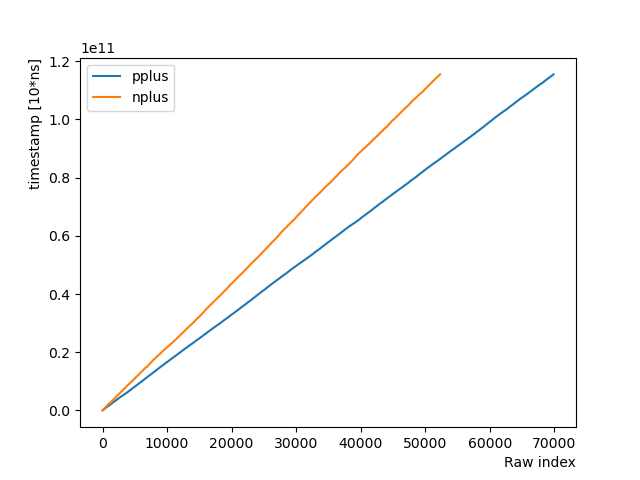

In [6]:
# look at timestamps
%matplotlib widget
plt.cla()
plt.plot(np.arange(len(df_pplus)), df_pplus['timestamp'], label='pplus')
plt.plot(np.arange(len(df_nplus)), df_nplus['timestamp'], label='nplus')
plt.xlabel('Raw index', ha='right', x=1)
plt.ylabel('timestamp [10*ns]', ha='right', y=1)
plt.legend()

In [8]:
# create time coincidence map.
%matplotlib widget


# test cluster_events with an extra fake channel, #7, with slightly changed timestamps
df_extra = df_nplus.copy()
df_extra['timestamp'] = gaussian_filter(df_extra['timestamp'], sigma=0.1)
df_extra['channel'] = 7
# print(df_nplus['timestamp'])
# print(df_extra['timestamp'])
    
# make a list of dataframes.  we can also make this a list of LH5 tables.
# We assume these are different tables from each channel, from a SINGLE cycle file.
tb_list = [df_pplus, df_nplus, df_extra]
# tb_list = [df_pplus, df_nplus]

# note: by requiring individual cycle files, cluster_events would work well as an 
# `apply` over cycle numbers, as we do in processing.py
tcm = cluster_events(tb_list, 1e-8, data_cols=df_pplus.columns)

tcm_view = ['channel','tcm_sec','tcm_dt','ix_evt','ix_hit','ix_row'] 

pd.options.display.max_rows = 50
pd.options.display.float_format = '{:,.3e}'.format
tcm[tcm_view].head(50)
# tcm.head(50)

,channel,tcm_sec,tcm_dt,ix_evt,ix_hit,ix_row
0,2,3.243e-02,NaN,0,0,0
1,7,3.243e-02,4.700e-07,0,1,0
2,6,3.243e-02,0.000e+00,0,2,0
3,2,3.414e-02,1.711e-03,1,0,1
4,7,3.414e-02,1.470e-06,1,1,1
5,6,3.414e-02,0.000e+00,1,2,1
6,2,4.153e-02,7.393e-03,2,0,2
7,6,4.154e-02,1.790e-06,2,1,2
8,7,4.154e-02,0.000e+00,2,2,2
9,2,5.388e-02,1.234e-02,3,0,3


In [ ]:
# retrieve waveforms for a few events of interest and plot them


    
# look up & retrieve waveforms from raw files using the TCM
wf_files = raw_files[:ncycles]
tcm_files = [tcm,]
que = 'trapEmax > 2000 and trapEmax < 2200' # HMM, how to select by one channel but still get wfs from the whole event?
n_evts = 10
    
tcm_wfs = lookup_wfs(wf_files, tcm_files, que, n_evts)